In [1]:
import sys

sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

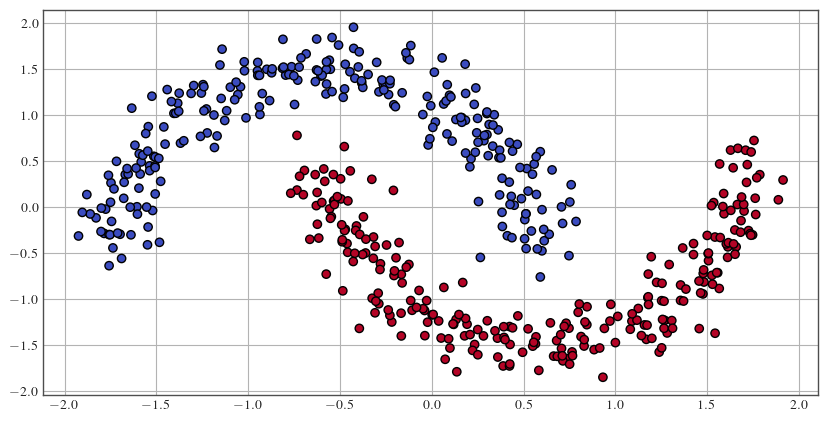

In [2]:
from sklearn import datasets
X, y = datasets.make_moons(500, noise=.1)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
from models.spectral_norm import spectral_norm_fc

class Net(nn.Module):
    def __init__(self, n_residual_layers=4, feature_dim=128, spectral_norm=True, coeff=1, n_power_iterations=1):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList(
            [nn.Linear(feature_dim, feature_dim) for _ in range(n_residual_layers)])
        self.last = nn.Linear(feature_dim, 2)

        # Add spectral norm
        if spectral_norm:
            for residual in self.residuals:
                spectral_norm_fc(
                    residual,
                    coeff=coeff,
                    n_power_iterations=n_power_iterations
                )

        self.act = nn.ELU()

    def forward(self, x, return_features=False):
        # : Added activation to first layer
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x)) + x
        features = x
        x = self.last(x)
        if return_features:
            return x, features
        return x

In [4]:
from models.sngp import SNGP, scale_logits
from utils import MetricLogger
from metrics import generalization

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch=None, print_freq=1000):
    model.train()
    model.reset_covariance()
    model.to(device)

    metric_logger = MetricLogger(delimiter=" ")
    header = f"Epoch [{epoch}]" if epoch is not None else "  Train: "

    # Train the epoch
    for inputs, targets in metric_logger.log_every(dataloader, print_freq, header):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = inputs.shape[0]
        acc1, = generalization.accuracy(outputs, targets, topk=(1,))
        metric_logger.update(loss=loss.item())
        metric_logger.meters["acc1"].update(acc1.item(), n=batch_size)

    train_stats = {f"train_{k}": meter.global_avg for k, meter, in metric_logger.meters.items()}
    return train_stats

Epoch [0] [ 0/16] eta: 0:00:00 loss: 0.6933 (0.6933) acc1: 50.0000 (50.0000) time: 0.0057 data: 0.0004 max mem: 0
Epoch [0] Total time: 0:00:00
Epoch [1] [ 0/16] eta: 0:00:00 loss: 0.6712 (0.6712) acc1: 100.0000 (100.0000) time: 0.0054 data: 0.0004 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [ 0/16] eta: 0:00:00 loss: 0.6582 (0.6582) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [ 0/16] eta: 0:00:00 loss: 0.6441 (0.6441) acc1: 100.0000 (100.0000) time: 0.0052 data: 0.0004 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [ 0/16] eta: 0:00:00 loss: 0.6313 (0.6313) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [4] Total time: 0:00:00
Epoch [5] [ 0/16] eta: 0:00:00 loss: 0.6229 (0.6229) acc1: 100.0000 (100.0000) time: 0.0049 data: 0.0003 max mem: 0
Epoch [5] Total time: 0:00:00
Epoch [6] [ 0/16] eta: 0:00:00 loss: 0.6137 (0.6137) acc1: 100.0000 (100.0000) time: 0.0051 data: 0.0004 max mem: 0
Epoch [6] 

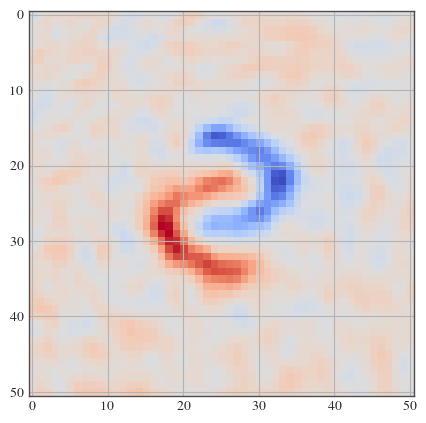

/tmp/ipykernel_24388/2465057140.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


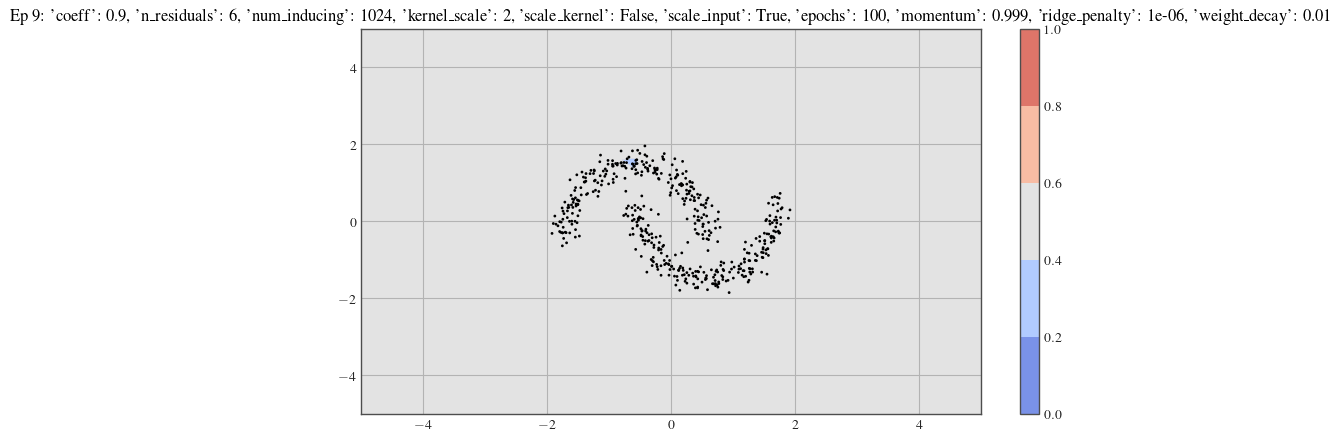

Epoch [10] [ 0/16] eta: 0:00:00 loss: 0.5823 (0.5823) acc1: 96.8750 (96.8750) time: 0.0055 data: 0.0003 max mem: 0
Epoch [10] Total time: 0:00:00
Epoch [11] [ 0/16] eta: 0:00:00 loss: 0.5527 (0.5527) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0003 max mem: 0
Epoch [11] Total time: 0:00:00
Epoch [12] [ 0/16] eta: 0:00:00 loss: 0.5465 (0.5465) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [12] Total time: 0:00:00
Epoch [13] [ 0/16] eta: 0:00:00 loss: 0.5263 (0.5263) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [13] Total time: 0:00:00
Epoch [14] [ 0/16] eta: 0:00:00 loss: 0.5204 (0.5204) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [14] Total time: 0:00:00
Epoch [15] [ 0/16] eta: 0:00:00 loss: 0.5095 (0.5095) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [15] Total time: 0:00:00
Epoch [16] [ 0/16] eta: 0:00:00 loss: 0.4942 (0.4942) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0003 max mem:

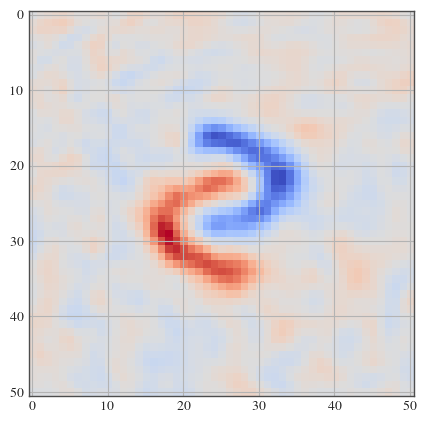

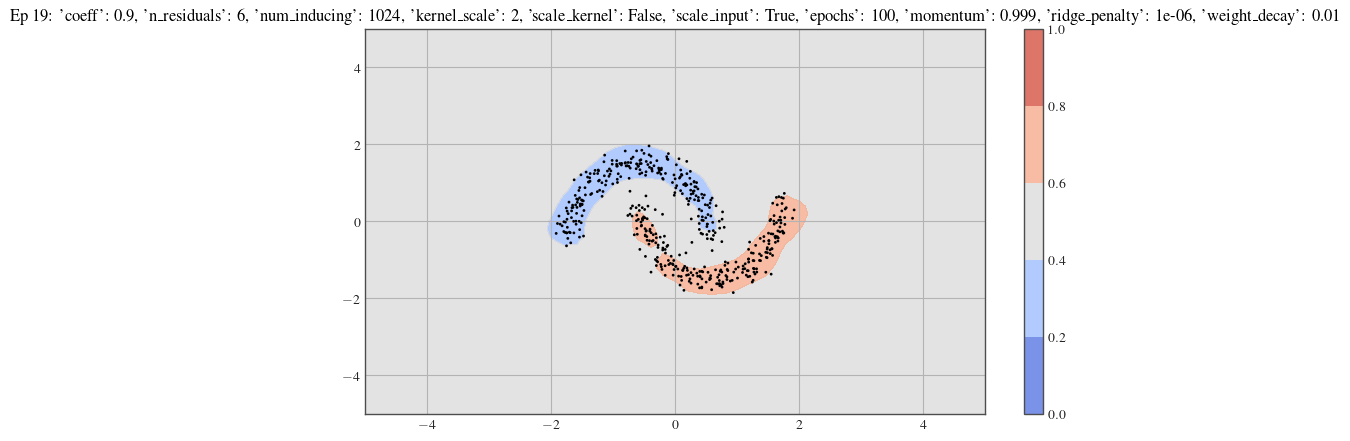

Epoch [20] [ 0/16] eta: 0:00:00 loss: 0.4592 (0.4592) acc1: 100.0000 (100.0000) time: 0.0054 data: 0.0003 max mem: 0
Epoch [20] Total time: 0:00:00
Epoch [21] [ 0/16] eta: 0:00:00 loss: 0.4509 (0.4509) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [21] Total time: 0:00:00
Epoch [22] [ 0/16] eta: 0:00:00 loss: 0.4546 (0.4546) acc1: 96.8750 (96.8750) time: 0.0045 data: 0.0003 max mem: 0
Epoch [22] Total time: 0:00:00
Epoch [23] [ 0/16] eta: 0:00:00 loss: 0.4505 (0.4505) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [23] Total time: 0:00:00
Epoch [24] [ 0/16] eta: 0:00:00 loss: 0.4184 (0.4184) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0003 max mem: 0
Epoch [24] Total time: 0:00:00
Epoch [25] [ 0/16] eta: 0:00:00 loss: 0.4090 (0.4090) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [25] Total time: 0:00:00
Epoch [26] [ 0/16] eta: 0:00:00 loss: 0.3959 (0.3959) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0003 max mem:

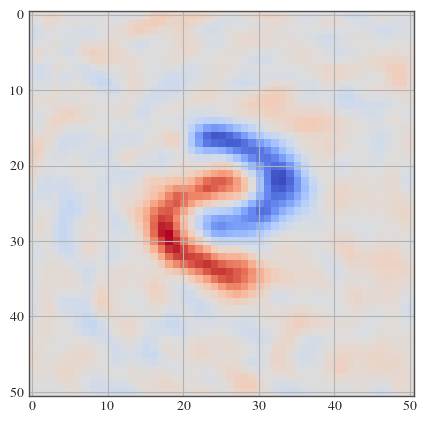

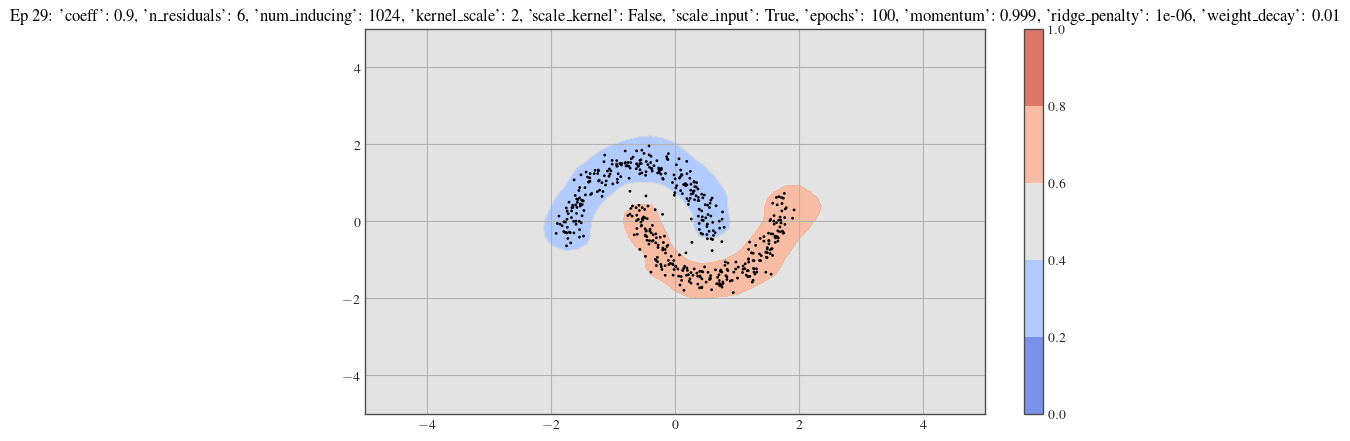

Epoch [30] [ 0/16] eta: 0:00:00 loss: 0.3747 (0.3747) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [30] Total time: 0:00:00
Epoch [31] [ 0/16] eta: 0:00:00 loss: 0.3707 (0.3707) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0003 max mem: 0
Epoch [31] Total time: 0:00:00
Epoch [32] [ 0/16] eta: 0:00:00 loss: 0.3451 (0.3451) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0003 max mem: 0
Epoch [32] Total time: 0:00:00
Epoch [33] [ 0/16] eta: 0:00:00 loss: 0.3528 (0.3528) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [33] Total time: 0:00:00
Epoch [34] [ 0/16] eta: 0:00:00 loss: 0.3444 (0.3444) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0003 max mem: 0
Epoch [34] Total time: 0:00:00
Epoch [35] [ 0/16] eta: 0:00:00 loss: 0.3366 (0.3366) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [35] Total time: 0:00:00
Epoch [36] [ 0/16] eta: 0:00:00 loss: 0.3171 (0.3171) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max me

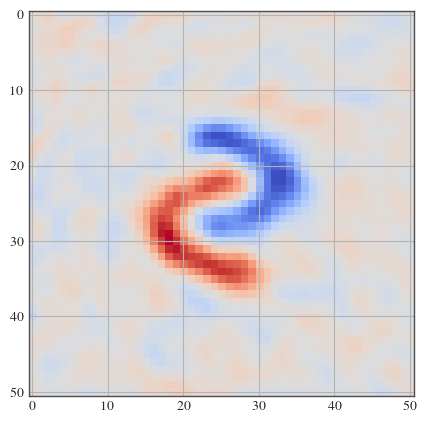

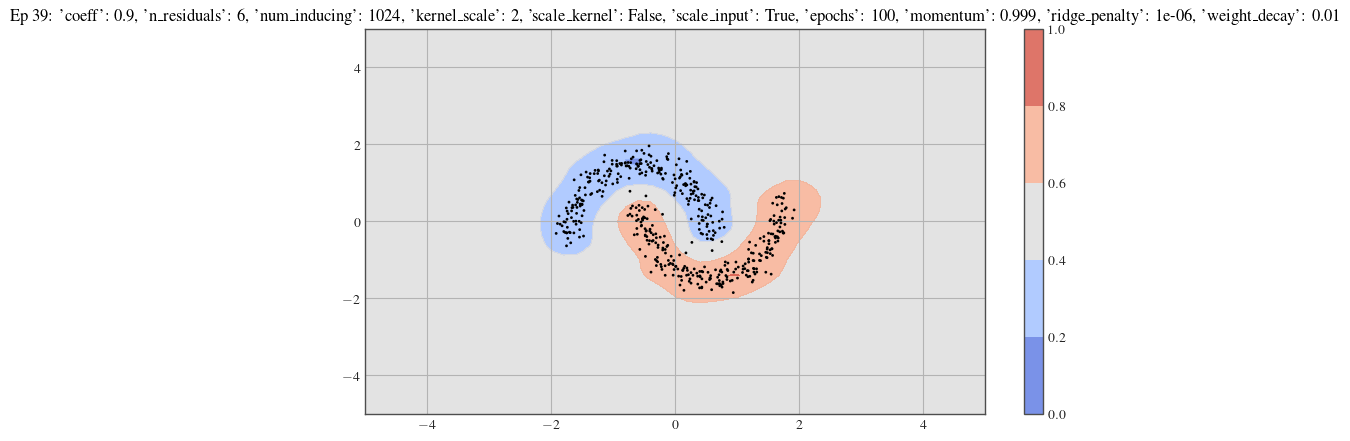

Epoch [40] [ 0/16] eta: 0:00:00 loss: 0.3030 (0.3030) acc1: 100.0000 (100.0000) time: 0.0059 data: 0.0003 max mem: 0
Epoch [40] Total time: 0:00:00
Epoch [41] [ 0/16] eta: 0:00:00 loss: 0.3122 (0.3122) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [41] Total time: 0:00:00
Epoch [42] [ 0/16] eta: 0:00:00 loss: 0.2961 (0.2961) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [42] Total time: 0:00:00
Epoch [43] [ 0/16] eta: 0:00:00 loss: 0.2604 (0.2604) acc1: 100.0000 (100.0000) time: 0.0051 data: 0.0003 max mem: 0
Epoch [43] Total time: 0:00:00
Epoch [44] [ 0/16] eta: 0:00:00 loss: 0.2968 (0.2968) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [44] Total time: 0:00:00
Epoch [45] [ 0/16] eta: 0:00:00 loss: 0.2823 (0.2823) acc1: 100.0000 (100.0000) time: 0.0052 data: 0.0003 max mem: 0
Epoch [45] Total time: 0:00:00
Epoch [46] [ 0/16] eta: 0:00:00 loss: 0.2609 (0.2609) acc1: 100.0000 (100.0000) time: 0.0049 data: 0.0003 max me

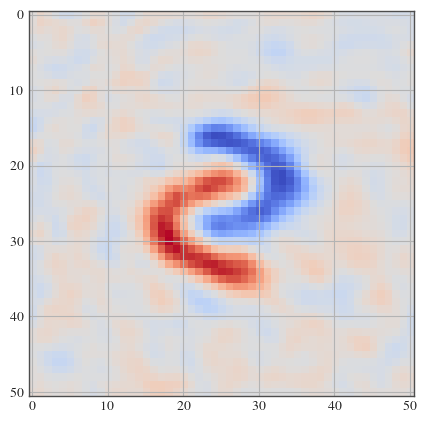

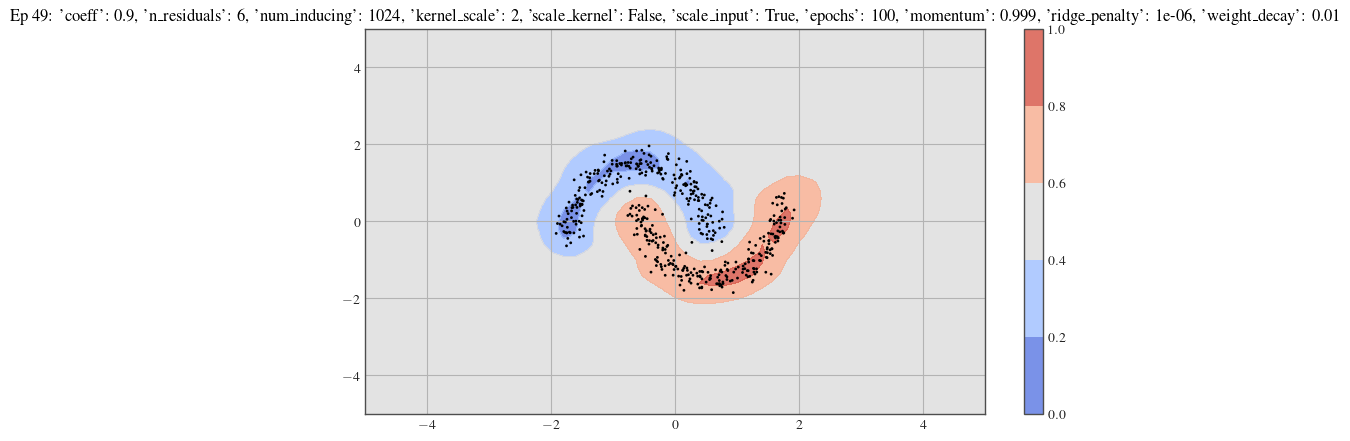

Epoch [50] [ 0/16] eta: 0:00:00 loss: 0.2467 (0.2467) acc1: 100.0000 (100.0000) time: 0.0056 data: 0.0003 max mem: 0
Epoch [50] Total time: 0:00:00
Epoch [51] [ 0/16] eta: 0:00:00 loss: 0.2690 (0.2690) acc1: 100.0000 (100.0000) time: 0.0049 data: 0.0003 max mem: 0
Epoch [51] Total time: 0:00:00
Epoch [52] [ 0/16] eta: 0:00:00 loss: 0.2505 (0.2505) acc1: 96.8750 (96.8750) time: 0.0050 data: 0.0003 max mem: 0
Epoch [52] Total time: 0:00:00
Epoch [53] [ 0/16] eta: 0:00:00 loss: 0.2202 (0.2202) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [53] Total time: 0:00:00
Epoch [54] [ 0/16] eta: 0:00:00 loss: 0.2286 (0.2286) acc1: 100.0000 (100.0000) time: 0.0049 data: 0.0003 max mem: 0
Epoch [54] Total time: 0:00:00
Epoch [55] [ 0/16] eta: 0:00:00 loss: 0.2283 (0.2283) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [55] Total time: 0:00:00
Epoch [56] [ 0/16] eta: 0:00:00 loss: 0.2268 (0.2268) acc1: 100.0000 (100.0000) time: 0.0052 data: 0.0003 max mem:

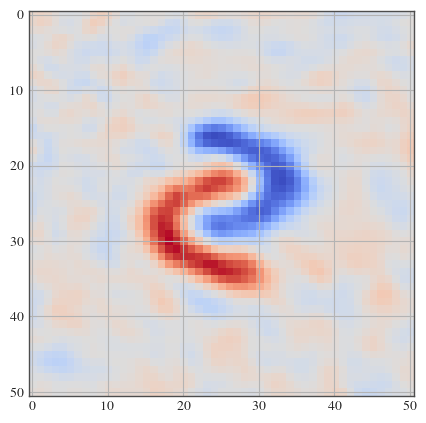

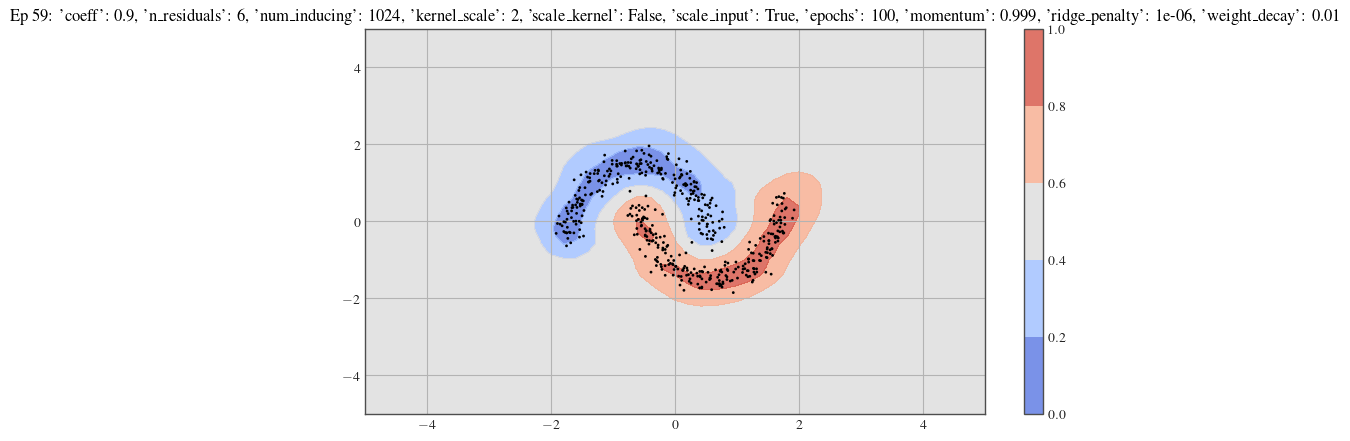

Epoch [60] [ 0/16] eta: 0:00:00 loss: 0.2082 (0.2082) acc1: 100.0000 (100.0000) time: 0.0052 data: 0.0003 max mem: 0
Epoch [60] Total time: 0:00:00
Epoch [61] [ 0/16] eta: 0:00:00 loss: 0.1920 (0.1920) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [61] Total time: 0:00:00
Epoch [62] [ 0/16] eta: 0:00:00 loss: 0.2273 (0.2273) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [62] Total time: 0:00:00
Epoch [63] [ 0/16] eta: 0:00:00 loss: 0.2036 (0.2036) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [63] Total time: 0:00:00
Epoch [64] [ 0/16] eta: 0:00:00 loss: 0.2107 (0.2107) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [64] Total time: 0:00:00
Epoch [65] [ 0/16] eta: 0:00:00 loss: 0.2233 (0.2233) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0003 max mem: 0
Epoch [65] Total time: 0:00:00
Epoch [66] [ 0/16] eta: 0:00:00 loss: 0.1781 (0.1781) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0003 max me

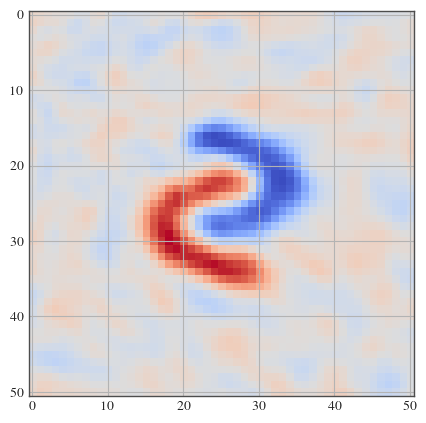

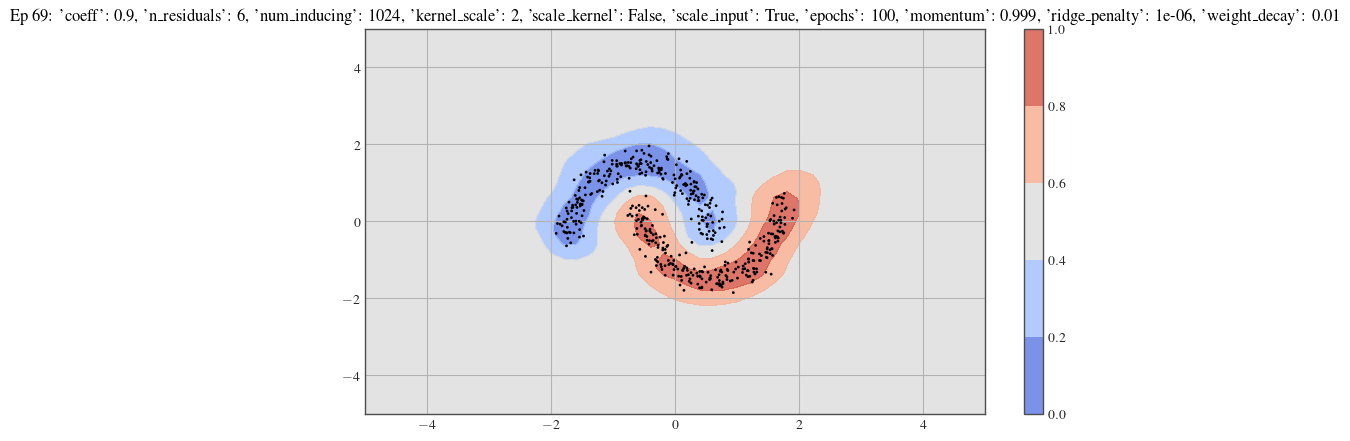

Epoch [70] [ 0/16] eta: 0:00:00 loss: 0.1754 (0.1754) acc1: 100.0000 (100.0000) time: 0.0049 data: 0.0003 max mem: 0
Epoch [70] Total time: 0:00:00
Epoch [71] [ 0/16] eta: 0:00:00 loss: 0.1626 (0.1626) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0003 max mem: 0
Epoch [71] Total time: 0:00:00
Epoch [72] [ 0/16] eta: 0:00:00 loss: 0.1750 (0.1750) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [72] Total time: 0:00:00
Epoch [73] [ 0/16] eta: 0:00:00 loss: 0.1743 (0.1743) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0003 max mem: 0
Epoch [73] Total time: 0:00:00
Epoch [74] [ 0/16] eta: 0:00:00 loss: 0.1643 (0.1643) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [74] Total time: 0:00:00
Epoch [75] [ 0/16] eta: 0:00:00 loss: 0.1601 (0.1601) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [75] Total time: 0:00:00
Epoch [76] [ 0/16] eta: 0:00:00 loss: 0.1753 (0.1753) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0003 max me

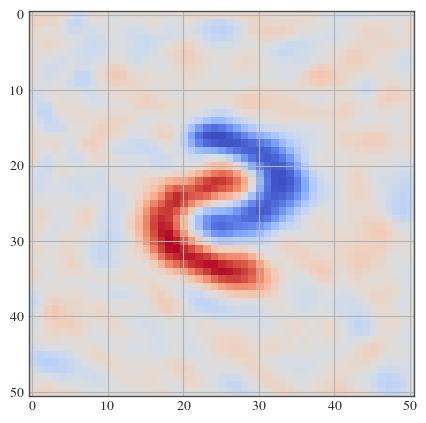

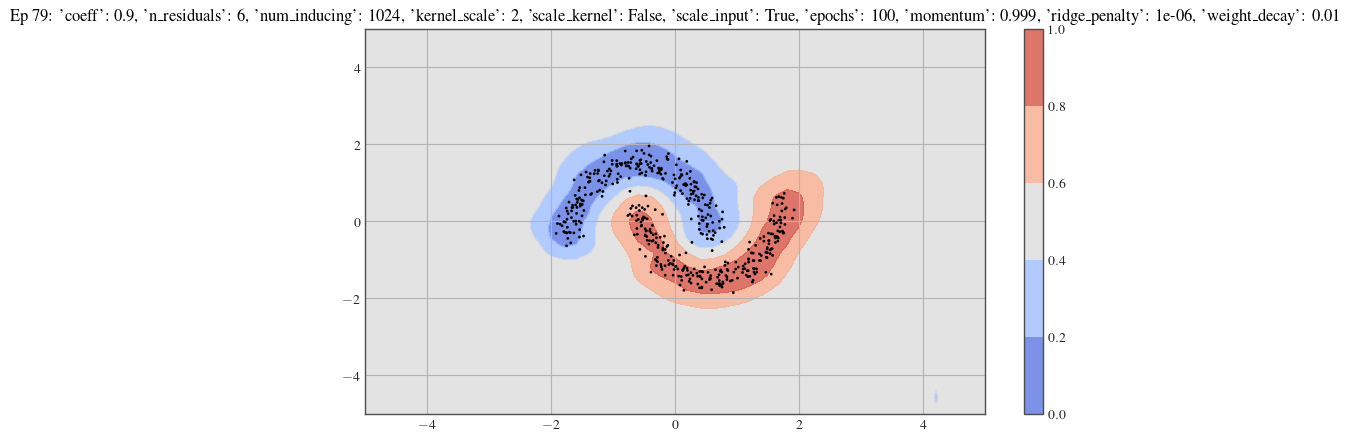

Epoch [80] [ 0/16] eta: 0:00:00 loss: 0.1464 (0.1464) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0003 max mem: 0
Epoch [80] Total time: 0:00:00
Epoch [81] [ 0/16] eta: 0:00:00 loss: 0.1802 (0.1802) acc1: 100.0000 (100.0000) time: 0.0042 data: 0.0003 max mem: 0
Epoch [81] Total time: 0:00:00
Epoch [82] [ 0/16] eta: 0:00:00 loss: 0.1482 (0.1482) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [82] Total time: 0:00:00
Epoch [83] [ 0/16] eta: 0:00:00 loss: 0.1553 (0.1553) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0003 max mem: 0
Epoch [83] Total time: 0:00:00
Epoch [84] [ 0/16] eta: 0:00:00 loss: 0.1504 (0.1504) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0003 max mem: 0
Epoch [84] Total time: 0:00:00
Epoch [85] [ 0/16] eta: 0:00:00 loss: 0.1814 (0.1814) acc1: 100.0000 (100.0000) time: 0.0042 data: 0.0003 max mem: 0
Epoch [85] Total time: 0:00:00
Epoch [86] [ 0/16] eta: 0:00:00 loss: 0.1538 (0.1538) acc1: 100.0000 (100.0000) time: 0.0042 data: 0.0003 max me

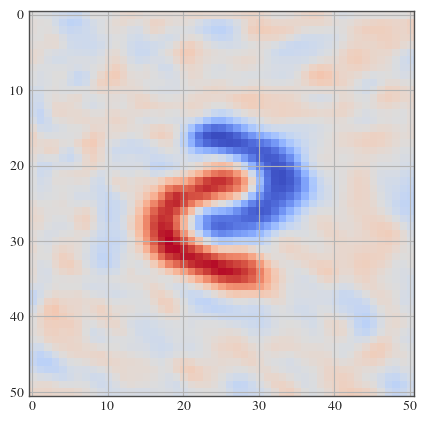

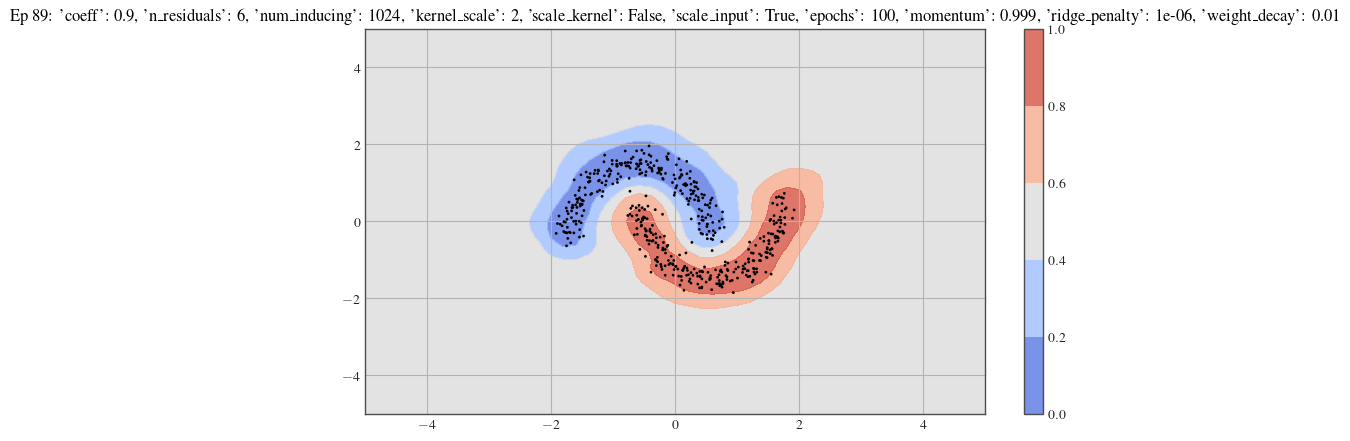

Epoch [90] [ 0/16] eta: 0:00:00 loss: 0.1432 (0.1432) acc1: 100.0000 (100.0000) time: 0.0051 data: 0.0003 max mem: 0
Epoch [90] Total time: 0:00:00
Epoch [91] [ 0/16] eta: 0:00:00 loss: 0.1434 (0.1434) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0003 max mem: 0
Epoch [91] Total time: 0:00:00
Epoch [92] [ 0/16] eta: 0:00:00 loss: 0.1508 (0.1508) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0003 max mem: 0
Epoch [92] Total time: 0:00:00
Epoch [93] [ 0/16] eta: 0:00:00 loss: 0.1568 (0.1568) acc1: 96.8750 (96.8750) time: 0.0046 data: 0.0003 max mem: 0
Epoch [93] Total time: 0:00:00
Epoch [94] [ 0/16] eta: 0:00:00 loss: 0.1280 (0.1280) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0003 max mem: 0
Epoch [94] Total time: 0:00:00
Epoch [95] [ 0/16] eta: 0:00:00 loss: 0.1361 (0.1361) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0003 max mem: 0
Epoch [95] Total time: 0:00:00
Epoch [96] [ 0/16] eta: 0:00:00 loss: 0.1291 (0.1291) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0003 max mem:

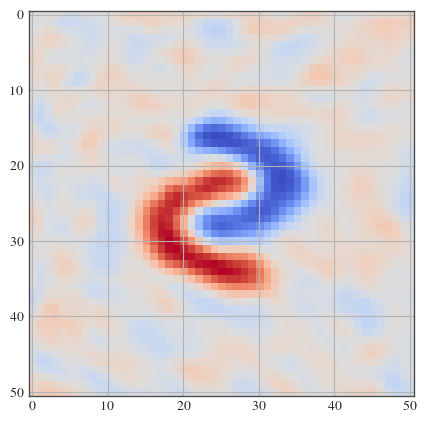

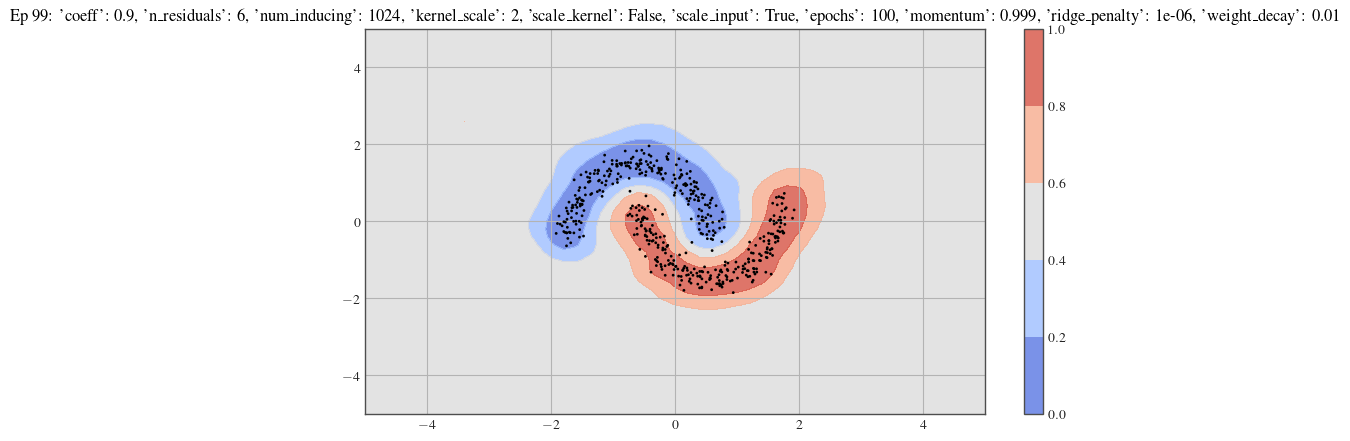

In [24]:
hparams = {
    'coeff': .9,
    'n_residuals': 6,
    'num_inducing': 1024,
    'kernel_scale': 2,
    'scale_kernel': False,
    'scale_input': True,
    'epochs': 100,
    'momentum': .999,
    'ridge_penalty': 1e-6,
    'weight_decay': 1e-2,
}
torch.manual_seed(0)
model = SNGP(
    model=Net(coeff=hparams['coeff'], n_residual_layers=hparams['n_residuals']),
    in_features=128,
    num_classes=2,
    num_inducing=hparams['num_inducing'],
    kernel_scale=hparams['kernel_scale'],
    momentum=hparams['momentum'],
    scale_input=hparams['scale_input'],
    scale_kernel=hparams['scale_kernel'],
    ridge_penalty=hparams['ridge_penalty']
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=hparams['weight_decay'])
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=hparams['weight_decay'])
criterion = nn.CrossEntropyLoss()
for i in range(hparams['epochs']):
    train_one_epoch(model, train_loader, criterion, optimizer, device='cpu', epoch=i)
    if (i+1) % (hparams['epochs'] // 10) == 0:
        model.eval()
        xx, yy = torch.meshgrid(torch.linspace(-5, 5, 51), torch.linspace(-5, 5, 51))
        zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

        with torch.no_grad():
            logits, cov = model(zz, return_cov=True, update_precision=False)

        # torch.distributions.MultivariateNormal(logits[:, 1], )
        # mean field approx
        logits = scale_logits(logits, cov)
        probas = logits.softmax(-1)
        zz = probas[:, 1].view(xx.shape)

        plt.title(f"Ep {i}: {hparams}")
        plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
        plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
        plt.colorbar()
        plt.show()

In [25]:

logits = model.forward_sample(zz, 1000)

probas = logits.softmax(-1)
# probas = logits.sigmoid()

plt.title(hparams)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
#contour = plt.contourf(xx, yy, probas.mean(0)[:, 1].view(xx.shape), alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
for i_member in [4]:# range(1):
    contour = plt.contourf(xx, yy, probas[i_member, :, 1].view(xx.shape), alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.contour(xx, yy, probas[i_member, :, 1].view(xx.shape), alpha=.8, zorder=-1, levels=[0.5])
plt.colorbar(contour)
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (51x51 and 2x128)